<a href="https://colab.research.google.com/github/mymph/rn-atividade2/blob/main/treinamento-mlp-atividade2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip -q install nba_api optuna

In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from nba_api.stats.endpoints import leaguegamefinder
warnings.filterwarnings('ignore')

In [46]:
# ID do Boston Celtics
TEAM_ID = 1610612738

# Coletar dados da temporada
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=TEAM_ID, season_nullable='2024-25')
df = gamefinder.get_data_frames()[0]

print("Dados carregados:")
print(f"Shape: {df.shape}")
print(df.head())

Dados carregados:
Shape: (98, 28)
  SEASON_ID     TEAM_ID TEAM_ABBREVIATION       TEAM_NAME     GAME_ID  \
0     42024  1610612738               BOS  Boston Celtics  0042400216   
1     42024  1610612738               BOS  Boston Celtics  0042400215   
2     42024  1610612738               BOS  Boston Celtics  0042400214   
3     42024  1610612738               BOS  Boston Celtics  0042400213   
4     42024  1610612738               BOS  Boston Celtics  0042400212   

    GAME_DATE      MATCHUP WL  MIN  PTS  ...  FT_PCT  OREB  DREB  REB  AST  \
0  2025-05-16    BOS @ NYK  L  241   81  ...   0.700     9    27   36   19   
1  2025-05-14  BOS vs. NYK  W  242  127  ...   0.654    12    32   44   27   
2  2025-05-12    BOS @ NYK  L  241  113  ...   0.731     7    24   31   15   
3  2025-05-10    BOS @ NYK  W  242  115  ...   0.882    12    30   42   23   
4  2025-05-07  BOS vs. NYK  L  240   90  ...   0.800    16    35   51   17   

   STL  BLK  TOV  PF  PLUS_MINUS  
0    4    3   15  22   

In [47]:
df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])
df = df.sort_values("GAME_DATE")

# Renomear colunas (igual à atividade 1)
df = df.rename(columns={
    "GAME_DATE": "Data do Jogo",
    "MATCHUP": "Confronto",
    "WL": "Vitória/Derrota",
    "PTS": "Pontos",
    "REB": "Rebotes",
    "AST": "Assistências",
    "FGM": "Arremessos Convertidos",
    "FGA": "Arremessos Tentados",
    "FG_PCT": "Percentual de Arremesso",
    "FG3M": "Cestas de 3 Convertidas",
    "FG3A": "Cestas de 3 Tentativas",
    "FG3_PCT": "Percentual de 3 Pontos",
    "FTM": "Lances Livres Convertidos",
    "FTA": "Lances Livres Tentados",
    "FT_PCT": "Percentual de Lances Livres",
    "OREB": "Rebotes Ofensivos",
    "DREB": "Rebotes Defensivos",
    "STL": "Roubos de Bola",
    "BLK": "Tocos",
    "TOV": "Erros (Turnovers)",
    "PF": "Faltas",
    "PLUS_MINUS": "+/-"
})

# Processar coluna 'Confronto' para extrair informações úteis: adversário e se é em casa/fora
def processar_confronto(confronto):
    if 'vs.' in confronto:
        return 'Casa', confronto.split('vs. ')[1].strip()
    elif '@' in confronto:
        return 'Fora', confronto.split('@ ')[1].strip()
    else:
        return 'Neutro', 'Desconhecido'

# Aplicar processamento
df[['Local', 'Adversario']] = df['Confronto'].apply(
    lambda x: pd.Series(processar_confronto(x))
)

# Codificar adversários (transformar em números)
le_adversario = LabelEncoder()
df['Adversario_Encoded'] = le_adversario.fit_transform(df['Adversario'])

# Codificar local (Casa=1, Fora=0, Neutro=0.5)
df['Local_Encoded'] = df['Local'].map({'Casa': 1, 'Fora': 0, 'Neutro': 0.5})

print(f"Adversários únicos encontrados: {len(le_adversario.classes_)}")
print(f"Distribuição de local: {df['Local'].value_counts().to_dict()}")

Adversários únicos encontrados: 30
Distribuição de local: {'Fora': 49, 'Casa': 49}


In [48]:
# Definir features iniciais (REMOVENDO as que não fazem sentido)
features_nao_permitidas = ["SEASON_ID", "TEAM_ID", "TEAM_ABBREVIATION", "TEAM_NAME", "GAME_ID", "Data do Jogo", "Confronto", "Local", "Adversario"]

# Todas as colunas numéricas disponíveis
todas_colunas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

# Filtrar apenas as que fazem sentido para o modelo
features_mlp = [col for col in todas_colunas_numericas if col not in features_nao_permitidas]

# Adicionar as features processadas do confronto
features_mlp.extend(['Local_Encoded', 'Adversario_Encoded'])
features_mlp = list(set(features_mlp))

print(f"\nFeatures selecionadas para MLP ({len(features_mlp)}):")
for i, feature in enumerate(features_mlp, 1):
    print(f"  {i:2d}. {feature}")


Features selecionadas para MLP (22):
   1. Roubos de Bola
   2. Adversario_Encoded
   3. Rebotes Ofensivos
   4. Erros (Turnovers)
   5. Percentual de 3 Pontos
   6. Lances Livres Convertidos
   7. +/-
   8. MIN
   9. Cestas de 3 Tentativas
  10. Arremessos Convertidos
  11. Faltas
  12. Rebotes
  13. Pontos
  14. Cestas de 3 Convertidas
  15. Local_Encoded
  16. Percentual de Arremesso
  17. Rebotes Defensivos
  18. Arremessos Tentados
  19. Lances Livres Tentados
  20. Percentual de Lances Livres
  21. Tocos
  22. Assistências


In [49]:
# Preparar target
df['TARGET'] = df['Vitória/Derrota'].map({'W': 1, 'L': 0})

print(f"\nDistribuição do target:")
print(df['Vitória/Derrota'].value_counts())
print(f"Total de jogos: {len(df)}")


Distribuição do target:
Vitória/Derrota
W    71
L    27
Name: count, dtype: int64
Total de jogos: 98


In [50]:
# split
X = df[features_mlp]
y = df['TARGET']

# treino+validação vs teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nShapes finais:")
print(f"  Treino: {X_train_scaled.shape}")
print(f"  Validação: {X_val_scaled.shape}")
print(f"  Teste: {X_test_scaled.shape}")

# Salvar o scaler
joblib.dump(scaler, 'scaler_mlp.pkl')
print("Scaler salvo: scaler_mlp.pkl")

# Salvar dados processados
df.to_csv("celtics_2024_25_processado.csv", index=False)
print("Dados processados salvos: celtics_2024_25_processado.csv")


Shapes finais:
  Treino: (54, 22)
  Validação: (14, 22)
  Teste: (30, 22)
Scaler salvo: scaler_mlp.pkl
Dados processados salvos: celtics_2024_25_processado.csv


In [51]:
# Optuna: função obetivo com feature selection
def objective_with_feature_selection(trial):

    # feature selection
    selected_features = []
    for feature in features_mlp:
        if trial.suggest_categorical(f'feature_{feature}', [True, False]):
            selected_features.append(feature)

    # Penalizar se não selecionou nenhuma feature
    if len(selected_features) == 0:
        return float('inf')

    # Criar subconjuntos com features selecionadas
    feature_indices = [features_mlp.index(f) for f in selected_features]
    X_train_subset = X_train_scaled[:, feature_indices]
    X_val_subset = X_val_scaled[:, feature_indices]

    # hiperparâmetros da arquitetura
    n_layers = trial.suggest_int('n_layers', 1, 3)
    units = []

    for i in range(n_layers):
        units.append(trial.suggest_int(f'n_units_layer_{i}', 8, 64))  # diminuí neurônios para evitar overfitting

    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # construção do modelo
    model = tf.keras.Sequential()

    # Camada de entrada
    model.add(tf.keras.layers.Dense(
        units[0],
        activation=activation,
        input_shape=(len(selected_features),)
    ))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Camadas ocultas
    for i in range(1, n_layers):
        model.add(tf.keras.layers.Dense(units[i], activation=activation))
        model.add(tf.keras.layers.Dropout(dropout_rate))

    # Camada de saída
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=0
    )

    # treino optuna
    history = model.fit(
        X_train_subset, y_train,
        epochs=80,
        batch_size=batch_size,
        validation_data=(X_val_subset, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # avaliação
    val_loss = min(history.history['val_loss'])
    trial.set_user_attr("selected_features", selected_features)
    trial.set_user_attr("n_features", len(selected_features))

    print(f"\n[SUMMARY] Trial {trial.number}:")
    print(f"  Features: {len(selected_features)} | Arch: {units}")
    print(f"  Act: {activation} | Opt: {optimizer_name} | LR: {learning_rate:.6f}")
    print(f"  Val Loss: {val_loss:.4f}")

    return val_loss

In [52]:
# executar otimização
study_with_fs = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(seed=42)
)
study_with_fs.optimize(objective_with_feature_selection, n_trials=50)

# resultados
print("Otimização concluída!")
print(f"Melhor val_loss: {study_with_fs.best_value:.4f}")

# Features selecionadas
best_features = [
    feature for feature in features_mlp
    if study_with_fs.best_trial.params.get(f'feature_{feature}', False)
]

print(f"Features selecionadas ({len(best_features)}):")
for i, feature in enumerate(best_features, 1):
    print(f"  {i:2d}. {feature}")

[I 2025-11-16 20:24:27,445] A new study created in memory with name: no-name-a2b0e467-4cac-4b83-946f-1d8428cd1e01
[I 2025-11-16 20:24:39,186] Trial 0 finished with value: 0.3069785237312317 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': False, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': False, 'feature_Cestas de 3 Tentativas': False, 'feature_Arremessos Convertidos': True, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': False, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': True, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 1, 'n_units_layer_0': 45, 'dr


[SUMMARY] Trial 0:
  Features: 10 | Arch: [45]
  Act: elu | Opt: rmsprop | LR: 0.001097
  Val Loss: 0.3070


[I 2025-11-16 20:24:51,003] Trial 1 finished with value: 0.5322626829147339 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': True, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': False, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 25, 'n_units_layer_1': 36, 'dropout_rate': 0.6630265895704371, 'learning_rate': 0.00031519872951938895, 'activation': 'tan


[SUMMARY] Trial 1:
  Features: 11 | Arch: [25, 36]
  Act: tanh | Opt: rmsprop | LR: 0.000315
  Val Loss: 0.5323


[I 2025-11-16 20:25:00,202] Trial 2 finished with value: 0.6781579256057739 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': False, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': True, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': True, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': False, 'feature_Assistências': True, 'n_layers': 3, 'n_units_layer_0': 28, 'n_units_layer_1': 44, 'n_units_layer_2': 44, 'dropout_rate': 0.5143098736299033, 'learning_rate': 0.00015155823539597


[SUMMARY] Trial 2:
  Features: 11 | Arch: [28, 44, 44]
  Act: relu | Opt: sgd | LR: 0.000152
  Val Loss: 0.6782


[I 2025-11-16 20:25:10,553] Trial 3 finished with value: 0.5877165198326111 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Arremessos Convertidos': True, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Local_Encoded': False, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': False, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': True, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 56, 'n_units_layer_1': 45, 'dropout_rate': 0.5273234413341886, 'learning_rate': 0.00015393931002140855, 'activation': 'relu'


[SUMMARY] Trial 3:
  Features: 13 | Arch: [56, 45]
  Act: relu | Opt: adam | LR: 0.000154
  Val Loss: 0.5877


[I 2025-11-16 20:25:20,273] Trial 4 finished with value: 0.6221675872802734 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': False, 'feature_Lances Livres Convertidos': True, 'feature_+/-': False, 'feature_MIN': False, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Local_Encoded': False, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': True, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': False, 'feature_Assistências': True, 'n_layers': 3, 'n_units_layer_0': 45, 'n_units_layer_1': 48, 'n_units_layer_2': 53, 'dropout_rate': 0.6560021367270265, 'learning_rate': 0.00047423140811121


[SUMMARY] Trial 4:
  Features: 11 | Arch: [45, 48, 53]
  Act: elu | Opt: sgd | LR: 0.000474
  Val Loss: 0.6222


[I 2025-11-16 20:25:30,510] Trial 5 finished with value: 0.481018602848053 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': False, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': True, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Local_Encoded': False, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': False, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': True, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 1, 'n_units_layer_0': 56, 'dropout_rate': 0.5814631437520095, 'learning_rate': 0.0008878664758716851, 'activation': 'tanh', 'optimizer': 'rmsprop'


[SUMMARY] Trial 5:
  Features: 12 | Arch: [56]
  Act: tanh | Opt: rmsprop | LR: 0.000888
  Val Loss: 0.4810


[I 2025-11-16 20:25:37,541] Trial 6 finished with value: 0.31953662633895874 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': False, 'feature_Lances Livres Convertidos': True, 'feature_+/-': False, 'feature_MIN': False, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': True, 'feature_Faltas': True, 'feature_Rebotes': True, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': False, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 52, 'n_units_layer_1': 27, 'dropout_rate': 0.6723029302414258, 'learning_rate': 0.005209853409855873, 'activation': 'elu


[SUMMARY] Trial 6:
  Features: 10 | Arch: [52, 27]
  Act: elu | Opt: rmsprop | LR: 0.005210
  Val Loss: 0.3195


[I 2025-11-16 20:25:50,806] Trial 7 finished with value: 0.7174903154373169 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': False, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': True, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Local_Encoded': False, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': True, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 3, 'n_units_layer_0': 39, 'n_units_layer_1': 32, 'n_units_layer_2': 59, 'dropout_rate': 0.34447899292246054, 'learning_rate': 0.0009666076069077


[SUMMARY] Trial 7:
  Features: 11 | Arch: [39, 32, 59]
  Act: tanh | Opt: sgd | LR: 0.000967
  Val Loss: 0.7175


[I 2025-11-16 20:26:05,670] Trial 8 finished with value: 0.6319445967674255 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': True, 'feature_+/-': False, 'feature_MIN': False, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': True, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Local_Encoded': False, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': False, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': True, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 3, 'n_units_layer_0': 42, 'n_units_layer_1': 31, 'n_units_layer_2': 61, 'dropout_rate': 0.6464255558001633, 'learning_rate': 0.0001231508291526038,


[SUMMARY] Trial 8:
  Features: 14 | Arch: [42, 31, 61]
  Act: elu | Opt: adam | LR: 0.000123
  Val Loss: 0.6319


[I 2025-11-16 20:26:16,235] Trial 9 finished with value: 0.21329236030578613 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': False, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': True, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 3, 'n_units_layer_0': 27, 'n_units_layer_1': 37, 'n_units_layer_2': 52, 'dropout_rate': 0.45861711292850804, 'learning_rate': 0.0017545809123068


[SUMMARY] Trial 9:
  Features: 12 | Arch: [27, 37, 52]
  Act: tanh | Opt: adam | LR: 0.001755
  Val Loss: 0.2133


[I 2025-11-16 20:26:26,161] Trial 10 finished with value: 0.1298232525587082 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 3, 'n_units_layer_0': 12, 'n_units_layer_1': 10, 'n_units_layer_2': 9, 'dropout_rate': 0.42271589556929445, 'learning_rate': 0.0052097041000830


[SUMMARY] Trial 10:
  Features: 11 | Arch: [12, 10, 9]
  Act: tanh | Opt: adam | LR: 0.005210
  Val Loss: 0.1298


[I 2025-11-16 20:26:42,173] Trial 11 finished with value: 0.11346188932657242 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 3, 'n_units_layer_0': 8, 'n_units_layer_1': 9, 'n_units_layer_2': 8, 'dropout_rate': 0.4099952873528384, 'learning_rate': 0.004798156216545938


[SUMMARY] Trial 11:
  Features: 11 | Arch: [8, 9, 8]
  Act: tanh | Opt: adam | LR: 0.004798
  Val Loss: 0.1135


[I 2025-11-16 20:27:03,719] Trial 12 finished with value: 0.17891046404838562 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 3, 'n_units_layer_0': 11, 'n_units_layer_1': 8, 'n_units_layer_2': 8, 'dropout_rate': 0.3678326117551006, 'learning_rate': 0.00918696514398901


[SUMMARY] Trial 12:
  Features: 11 | Arch: [11, 8, 8]
  Act: tanh | Opt: adam | LR: 0.009187
  Val Loss: 0.1789


[I 2025-11-16 20:27:16,168] Trial 13 finished with value: 0.30428627133369446 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 9, 'n_units_layer_1': 9, 'dropout_rate': 0.4036729409185229, 'learning_rate': 0.0035119571721548937, 'activation': 'tanh


[SUMMARY] Trial 13:
  Features: 11 | Arch: [9, 9]
  Act: tanh | Opt: adam | LR: 0.003512
  Val Loss: 0.3043


[I 2025-11-16 20:27:21,905] Trial 14 finished with value: 0.2501876950263977 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 3, 'n_units_layer_0': 17, 'n_units_layer_1': 18, 'n_units_layer_2': 10, 'dropout_rate': 0.4603815096021462, 'learning_rate': 0.0032239374780485


[SUMMARY] Trial 14:
  Features: 11 | Arch: [17, 18, 10]
  Act: tanh | Opt: adam | LR: 0.003224
  Val Loss: 0.2502


[I 2025-11-16 20:27:25,819] Trial 15 finished with value: 0.18470440804958344 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 18, 'n_units_layer_1': 58, 'dropout_rate': 0.3064990830564097, 'learning_rate': 0.008583310419151157, 'activation': 'tan


[SUMMARY] Trial 15:
  Features: 11 | Arch: [18, 58]
  Act: tanh | Opt: adam | LR: 0.008583
  Val Loss: 0.1847


[I 2025-11-16 20:27:40,214] Trial 16 finished with value: 0.20912976562976837 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 3, 'n_units_layer_0': 17, 'n_units_layer_1': 18, 'n_units_layer_2': 24, 'dropout_rate': 0.39569283112176123, 'learning_rate': 0.00236760869768


[SUMMARY] Trial 16:
  Features: 11 | Arch: [17, 18, 24]
  Act: relu | Opt: adam | LR: 0.002368
  Val Loss: 0.2091


[I 2025-11-16 20:27:47,477] Trial 17 finished with value: 0.36870500445365906 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 8, 'n_units_layer_1': 19, 'dropout_rate': 0.4669699924693705, 'learning_rate': 0.005694711626331483, 'activation': 'tanh


[SUMMARY] Trial 17:
  Features: 11 | Arch: [8, 19]
  Act: tanh | Opt: adam | LR: 0.005695
  Val Loss: 0.3687


[I 2025-11-16 20:28:00,088] Trial 18 finished with value: 0.23075519502162933 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': False, 'feature_Lances Livres Convertidos': True, 'feature_+/-': True, 'feature_MIN': False, 'feature_Cestas de 3 Tentativas': False, 'feature_Arremessos Convertidos': True, 'feature_Faltas': False, 'feature_Rebotes': True, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': True, 'feature_Assistências': False, 'n_layers': 1, 'n_units_layer_0': 21, 'dropout_rate': 0.5798861743825365, 'learning_rate': 0.0017924950842838016, 'activation': 'tanh', 'optimizer': 'ada


[SUMMARY] Trial 18:
  Features: 10 | Arch: [21]
  Act: tanh | Opt: adam | LR: 0.001792
  Val Loss: 0.2308


[I 2025-11-16 20:28:11,939] Trial 19 finished with value: 0.6824861168861389 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 3, 'n_units_layer_0': 33, 'n_units_layer_1': 14, 'n_units_layer_2': 22, 'dropout_rate': 0.30911999261152606, 'learning_rate': 0.005129242660546


[SUMMARY] Trial 19:
  Features: 11 | Arch: [33, 14, 22]
  Act: relu | Opt: sgd | LR: 0.005129
  Val Loss: 0.6825


[I 2025-11-16 20:28:22,926] Trial 20 finished with value: 0.0955318957567215 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 64, 'n_units_layer_1': 25, 'dropout_rate': 0.3580255173863724, 'learning_rate': 0.00315373656182238, 'activation': 'tanh'


[SUMMARY] Trial 20:
  Features: 11 | Arch: [64, 25]
  Act: tanh | Opt: adam | LR: 0.003154
  Val Loss: 0.0955


[I 2025-11-16 20:28:37,106] Trial 21 finished with value: 0.05618998035788536 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 64, 'n_units_layer_1': 24, 'dropout_rate': 0.35339392172312334, 'learning_rate': 0.002750812260428166, 'activation': 'ta


[SUMMARY] Trial 21:
  Features: 11 | Arch: [64, 24]
  Act: tanh | Opt: adam | LR: 0.002751
  Val Loss: 0.0562


[I 2025-11-16 20:28:45,610] Trial 22 finished with value: 0.14498411118984222 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 64, 'n_units_layer_1': 24, 'dropout_rate': 0.3522703043038186, 'learning_rate': 0.002378986556573801, 'activation': 'tan


[SUMMARY] Trial 22:
  Features: 11 | Arch: [64, 24]
  Act: tanh | Opt: adam | LR: 0.002379
  Val Loss: 0.1450


[I 2025-11-16 20:28:52,988] Trial 23 finished with value: 0.09861968457698822 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 61, 'n_units_layer_1': 26, 'dropout_rate': 0.3786640432081648, 'learning_rate': 0.0034868843724488617, 'activation': 'ta


[SUMMARY] Trial 23:
  Features: 11 | Arch: [61, 26]
  Act: tanh | Opt: adam | LR: 0.003487
  Val Loss: 0.0986


[I 2025-11-16 20:29:07,584] Trial 24 finished with value: 0.13612951338291168 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 63, 'n_units_layer_1': 23, 'dropout_rate': 0.3381560346548859, 'learning_rate': 0.0014967095829706233, 'activation': 'ta


[SUMMARY] Trial 24:
  Features: 11 | Arch: [63, 23]
  Act: tanh | Opt: adam | LR: 0.001497
  Val Loss: 0.1361


[I 2025-11-16 20:29:18,633] Trial 25 finished with value: 0.17719776928424835 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 1, 'n_units_layer_0': 58, 'dropout_rate': 0.37137052110841, 'learning_rate': 0.0030931429682341523, 'activation': 'tanh', 'optimizer': 'adam',


[SUMMARY] Trial 25:
  Features: 11 | Arch: [58]
  Act: tanh | Opt: adam | LR: 0.003093
  Val Loss: 0.1772


[I 2025-11-16 20:29:35,513] Trial 26 finished with value: 0.5540991425514221 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': False, 'feature_Lances Livres Convertidos': True, 'feature_+/-': False, 'feature_MIN': False, 'feature_Cestas de 3 Tentativas': False, 'feature_Arremessos Convertidos': True, 'feature_Faltas': False, 'feature_Rebotes': True, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': False, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 51, 'n_units_layer_1': 28, 'dropout_rate': 0.30180861509399337, 'learning_rate': 0.0006964144960627635, 'activation': 


[SUMMARY] Trial 26:
  Features: 8 | Arch: [51, 28]
  Act: tanh | Opt: adam | LR: 0.000696
  Val Loss: 0.5541


[I 2025-11-16 20:29:47,817] Trial 27 finished with value: 0.1595883071422577 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 60, 'n_units_layer_1': 37, 'dropout_rate': 0.3791093504795056, 'learning_rate': 0.002528765328060568, 'activation': 'tanh


[SUMMARY] Trial 27:
  Features: 11 | Arch: [60, 37]
  Act: tanh | Opt: adam | LR: 0.002529
  Val Loss: 0.1596


[I 2025-11-16 20:30:01,305] Trial 28 finished with value: 0.21635206043720245 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 49, 'n_units_layer_1': 25, 'dropout_rate': 0.33171233569441516, 'learning_rate': 0.0013400495805127178, 'activation': 'r


[SUMMARY] Trial 28:
  Features: 11 | Arch: [49, 25]
  Act: relu | Opt: rmsprop | LR: 0.001340
  Val Loss: 0.2164


[I 2025-11-16 20:30:13,003] Trial 29 finished with value: 0.3581302762031555 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': False, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': False, 'feature_Cestas de 3 Tentativas': False, 'feature_Arremessos Convertidos': True, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': False, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 1, 'n_units_layer_0': 62, 'dropout_rate': 0.44282940634536005, 'learning_rate': 0.007404435837115961, 'activation': 'elu', 'optimizer': 'sgd'


[SUMMARY] Trial 29:
  Features: 9 | Arch: [62]
  Act: elu | Opt: sgd | LR: 0.007404
  Val Loss: 0.3581


[I 2025-11-16 20:30:24,787] Trial 30 finished with value: 0.2046366035938263 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 1, 'n_units_layer_0': 55, 'dropout_rate': 0.48869976795986514, 'learning_rate': 0.003604057729252037, 'activation': 'elu', 'optimizer': 'rmspro


[SUMMARY] Trial 30:
  Features: 11 | Arch: [55]
  Act: elu | Opt: rmsprop | LR: 0.003604
  Val Loss: 0.2046


[I 2025-11-16 20:30:31,248] Trial 31 finished with value: 0.11866526305675507 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 64, 'n_units_layer_1': 20, 'dropout_rate': 0.4187001877377815, 'learning_rate': 0.004168373876377809, 'activation': 'tan


[SUMMARY] Trial 31:
  Features: 11 | Arch: [64, 20]
  Act: tanh | Opt: adam | LR: 0.004168
  Val Loss: 0.1187


[I 2025-11-16 20:30:37,875] Trial 32 finished with value: 0.15310029685497284 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 33, 'n_units_layer_1': 13, 'dropout_rate': 0.39259645521541203, 'learning_rate': 0.006376029429973885, 'activation': 'ta


[SUMMARY] Trial 32:
  Features: 11 | Arch: [33, 13]
  Act: tanh | Opt: adam | LR: 0.006376
  Val Loss: 0.1531


[I 2025-11-16 20:30:50,008] Trial 33 finished with value: 0.08126373589038849 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': True, 'feature_Rebotes': False, 'feature_Pontos': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': True, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': True, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': True, 'feature_Tocos': False, 'feature_Assistências': False, 'n_layers': 2, 'n_units_layer_0': 47, 'n_units_layer_1': 31, 'dropout_rate': 0.35468927549258744, 'learning_rate': 0.0021592048469778165, 'activation': 't


[SUMMARY] Trial 33:
  Features: 11 | Arch: [47, 31]
  Act: tanh | Opt: adam | LR: 0.002159
  Val Loss: 0.0813


[I 2025-11-16 20:31:01,939] Trial 34 finished with value: 0.040697481483221054 and parameters: {'feature_Roubos de Bola': False, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 48, 'n_units_layer_1': 33, 'dropout_rate': 0.3576920938621462, 'learning_rate': 0.0020703651302638537, 'activation': '


[SUMMARY] Trial 34:
  Features: 10 | Arch: [48, 33]
  Act: tanh | Opt: adam | LR: 0.002070
  Val Loss: 0.0407


[I 2025-11-16 20:31:14,068] Trial 35 finished with value: 0.06284434348344803 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': True, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 45, 'n_units_layer_1': 33, 'dropout_rate': 0.33528335443189505, 'learning_rate': 0.0019073442028562891, 'activation': 'ta


[SUMMARY] Trial 35:
  Features: 12 | Arch: [45, 33]
  Act: tanh | Opt: adam | LR: 0.001907
  Val Loss: 0.0628


[I 2025-11-16 20:31:25,675] Trial 36 finished with value: 0.6928519010543823 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': False, 'feature_Lances Livres Convertidos': True, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': True, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Local_Encoded': False, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': True, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 46, 'n_units_layer_1': 33, 'dropout_rate': 0.32837162007331533, 'learning_rate': 0.0011967310202037388, 'activation': 'relu'


[SUMMARY] Trial 36:
  Features: 14 | Arch: [46, 33]
  Act: relu | Opt: sgd | LR: 0.001197
  Val Loss: 0.6929


[I 2025-11-16 20:31:32,056] Trial 37 finished with value: 0.5848191976547241 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': True, 'feature_+/-': False, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Arremessos Convertidos': True, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': False, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 42, 'n_units_layer_1': 36, 'dropout_rate': 0.5491083891537318, 'learning_rate': 0.0006896793234911878, 'activation': 'ta


[SUMMARY] Trial 37:
  Features: 10 | Arch: [42, 36]
  Act: tanh | Opt: rmsprop | LR: 0.000690
  Val Loss: 0.5848


[I 2025-11-16 20:31:43,902] Trial 38 finished with value: 0.3860577940940857 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': True, 'feature_+/-': True, 'feature_MIN': False, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': True, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': True, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 48, 'n_units_layer_1': 41, 'dropout_rate': 0.3259857046848129, 'learning_rate': 0.00033620185760078325, 'activation': 'tanh'


[SUMMARY] Trial 38:
  Features: 14 | Arch: [48, 41]
  Act: tanh | Opt: adam | LR: 0.000336
  Val Loss: 0.3861


[I 2025-11-16 20:31:49,361] Trial 39 finished with value: 0.5242258906364441 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': False, 'feature_Lances Livres Convertidos': True, 'feature_+/-': False, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': False, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': False, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 1, 'n_units_layer_0': 36, 'dropout_rate': 0.43110635896603305, 'learning_rate': 0.0019553126396974234, 'activation': 'elu', 'optimizer': 'rms


[SUMMARY] Trial 39:
  Features: 9 | Arch: [36]
  Act: elu | Opt: rmsprop | LR: 0.001955
  Val Loss: 0.5242


[I 2025-11-16 20:31:59,552] Trial 40 finished with value: 0.666911780834198 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': True, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Arremessos Convertidos': True, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Local_Encoded': False, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': True, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 42, 'n_units_layer_1': 40, 'dropout_rate': 0.3489425007313459, 'learning_rate': 0.0007164802124219907, 'activation': 'tanh',


[SUMMARY] Trial 40:
  Features: 13 | Arch: [42, 40]
  Act: tanh | Opt: sgd | LR: 0.000716
  Val Loss: 0.6669


[I 2025-11-16 20:32:07,616] Trial 41 finished with value: 0.13120649755001068 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': True, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 54, 'n_units_layer_1': 30, 'dropout_rate': 0.35769175210734216, 'learning_rate': 0.002696894890805109, 'activation': 'tan


[SUMMARY] Trial 41:
  Features: 12 | Arch: [54, 30]
  Act: tanh | Opt: adam | LR: 0.002697
  Val Loss: 0.1312


[I 2025-11-16 20:32:19,179] Trial 42 finished with value: 0.05764446780085564 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 58, 'n_units_layer_1': 34, 'dropout_rate': 0.3863643486087131, 'learning_rate': 0.0019885790397234527, 'activation': 'ta


[SUMMARY] Trial 42:
  Features: 11 | Arch: [58, 34]
  Act: tanh | Opt: adam | LR: 0.001989
  Val Loss: 0.0576


[I 2025-11-16 20:32:30,079] Trial 43 finished with value: 0.06016191840171814 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 58, 'n_units_layer_1': 51, 'dropout_rate': 0.32596725275198973, 'learning_rate': 0.0015696224853594268, 'activation': 't


[SUMMARY] Trial 43:
  Features: 11 | Arch: [58, 51]
  Act: tanh | Opt: adam | LR: 0.001570
  Val Loss: 0.0602


[I 2025-11-16 20:32:42,654] Trial 44 finished with value: 0.23322701454162598 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': True, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 57, 'n_units_layer_1': 47, 'dropout_rate': 0.3178699747439283, 'learning_rate': 0.0015336593616556392, 'activation': 'tan


[SUMMARY] Trial 44:
  Features: 12 | Arch: [57, 47]
  Act: tanh | Opt: adam | LR: 0.001534
  Val Loss: 0.2332


[I 2025-11-16 20:33:06,207] Trial 45 finished with value: 0.4568340480327606 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': False, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 52, 'n_units_layer_1': 53, 'dropout_rate': 0.38443748780829456, 'learning_rate': 0.0010538764116675412, 'activation': 't


[SUMMARY] Trial 45:
  Features: 10 | Arch: [52, 53]
  Act: tanh | Opt: adam | LR: 0.001054
  Val Loss: 0.4568


[I 2025-11-16 20:33:19,372] Trial 46 finished with value: 0.1221393495798111 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': False, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': True, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 59, 'n_units_layer_1': 43, 'dropout_rate': 0.33800977745821154, 'learning_rate': 0.0008825849970597888, 'activation': 'ta


[SUMMARY] Trial 46:
  Features: 11 | Arch: [59, 43]
  Act: tanh | Opt: adam | LR: 0.000883
  Val Loss: 0.1221


[I 2025-11-16 20:33:33,314] Trial 47 finished with value: 0.11113480478525162 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': False, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': False, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': True, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 55, 'n_units_layer_1': 64, 'dropout_rate': 0.3010345296131194, 'learning_rate': 0.0016532445929564358, 'activation': 'el


[SUMMARY] Trial 47:
  Features: 11 | Arch: [55, 64]
  Act: elu | Opt: adam | LR: 0.001653
  Val Loss: 0.1111


[I 2025-11-16 20:33:47,823] Trial 48 finished with value: 0.28762370347976685 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': True, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 44, 'n_units_layer_1': 35, 'dropout_rate': 0.4045885495697964, 'learning_rate': 0.001358508786349273, 'activation': 'relu


[SUMMARY] Trial 48:
  Features: 12 | Arch: [44, 35]
  Act: relu | Opt: adam | LR: 0.001359
  Val Loss: 0.2876


[I 2025-11-16 20:34:07,511] Trial 49 finished with value: 0.20584389567375183 and parameters: {'feature_Roubos de Bola': True, 'feature_Adversario_Encoded': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Percentual de 3 Pontos': True, 'feature_Lances Livres Convertidos': False, 'feature_+/-': True, 'feature_MIN': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Arremessos Convertidos': False, 'feature_Faltas': False, 'feature_Rebotes': False, 'feature_Pontos': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Local_Encoded': True, 'feature_Percentual de Arremesso': False, 'feature_Rebotes Defensivos': True, 'feature_Arremessos Tentados': False, 'feature_Lances Livres Tentados': False, 'feature_Percentual de Lances Livres': False, 'feature_Tocos': True, 'feature_Assistências': True, 'n_layers': 2, 'n_units_layer_0': 51, 'n_units_layer_1': 53, 'dropout_rate': 0.36880657880581763, 'learning_rate': 0.0004995496401669394, 'activation': 'ta


[SUMMARY] Trial 49:
  Features: 12 | Arch: [51, 53]
  Act: tanh | Opt: adam | LR: 0.000500
  Val Loss: 0.2058
Otimização concluída!
Melhor val_loss: 0.0407
Features selecionadas (10):
   1. Erros (Turnovers)
   2. Percentual de 3 Pontos
   3. +/-
   4. MIN
   5. Cestas de 3 Tentativas
   6. Pontos
   7. Local_Encoded
   8. Rebotes Defensivos
   9. Tocos
  10. Assistências


In [53]:
# modelo final com feature selection e arquitetura otimizada
def create_final_model_with_fs(best_params, best_features):

    # Preparar dados com features selecionadas
    feature_indices = [features_mlp.index(f) for f in best_features]
    X_train_final = X_train_scaled[:, feature_indices]
    X_val_final = X_val_scaled[:, feature_indices]
    X_test_final = X_test_scaled[:, feature_indices]

    # Construir modelo
    model = tf.keras.Sequential()
    n_layers = best_params['n_layers']
    activation = best_params['activation']
    dropout_rate = best_params['dropout_rate']

    # Camada de entrada
    model.add(tf.keras.layers.Dense(
        best_params['n_units_layer_0'],
        activation=activation,
        input_shape=(len(best_features),)
    ))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Camadas ocultas
    for i in range(1, n_layers):
        model.add(tf.keras.layers.Dense(
            best_params[f'n_units_layer_{i}'],
            activation=activation
        ))
        model.add(tf.keras.layers.Dropout(dropout_rate))

    # Camada de saída
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilar
    if best_params['optimizer'] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=best_params['learning_rate'])

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall', 'auc']
    )

    return model, X_train_final, X_val_final, X_test_final

# Criar e treinar modelo final
final_model, X_train_fs, X_val_fs, X_test_fs = create_final_model_with_fs(
    study_with_fs.best_trial.params,
    best_features
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Treinar
history_final = final_model.fit(
    X_train_fs, y_train,
    epochs=150,
    batch_size=study_with_fs.best_trial.params['batch_size'],
    validation_data=(X_val_fs, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.5185 - auc: 0.5556 - loss: 0.7340 - precision: 0.7241 - recall: 0.5385 - val_accuracy: 0.6429 - val_auc: 0.8875 - val_loss: 0.5844 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7778 - auc: 0.8496 - loss: 0.5502 - precision: 0.9355 - recall: 0.7436 - val_accuracy: 0.7143 - val_auc: 0.9000 - val_loss: 0.5446 - val_precision: 1.0000 - val_recall: 0.6000
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7407 - auc: 0.9291 - loss: 0.4602 - precision: 0.9630 - recall: 0.6667 - val_accuracy: 0.6429 - val_auc: 0.9000 - val_loss: 0.5177 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6481 - auc: 0.7940 - loss: 0.5610 - precision: 0.8571 - recall: 0.6154 - val_accuracy: 0.6429 - val_auc: 0.9000 - val_loss: 0.4972 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s

In [54]:
# Salvar modelo e metadados
final_model.save('modelo_mlp_celtics_fs.h5')

# Salvar informações de feature selection
fs_info = {
    'best_features': best_features,
    'best_params': study_with_fs.best_trial.params,
    'feature_importance': {f: study_with_fs.best_trial.params.get(f'feature_{f}', False) for f in features_mlp},
    'all_features_tested': features_mlp,
    'scaler': scaler,
    'input_shape': len(best_features)
}

joblib.dump(fs_info, 'feature_selection_info.pkl')

print("MODELO COM FEATURE SELECTION SALVO!")
print(f"Features finais ({len(best_features)}): {best_features}")

MODELO COM FEATURE SELECTION SALVO!
Features finais (10): ['Erros (Turnovers)', 'Percentual de 3 Pontos', '+/-', 'MIN', 'Cestas de 3 Tentativas', 'Pontos', 'Local_Encoded', 'Rebotes Defensivos', 'Tocos', 'Assistências']


In [55]:
# avaliação completa do modelo final

# Fazer previsões no conjunto de teste
y_pred_proba = final_model.predict(X_test_fs)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# métricas de classificação
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("\nMÉTRICAS DE CLASSIFICAÇÃO:")
print(f"  • Acurácia: {accuracy:.4f}")
print(f"  • Precisão: {precision:.4f}")
print(f"  • Recall: {recall:.4f}")
print(f"  • F1-Score: {f1:.4f}")
print(f"  • AUC-ROC: {auc_roc:.4f}")

mae_proba = mean_absolute_error(y_test, y_pred_proba)
rmse_proba = np.sqrt(mean_squared_error(y_test, y_pred_proba))
r2_proba = r2_score(y_test, y_pred_proba)

print("\nMÉTRICAS NAS PROBABILIDADES:")
print(f"  • MAE (Mean Absolute Error): {mae_proba:.4f}")
print(f"  • RMSE (Root Mean Squared Error): {rmse_proba:.4f}")
print(f"  • R² Score: {r2_proba:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

MÉTRICAS DE CLASSIFICAÇÃO:
  • Acurácia: 1.0000
  • Precisão: 1.0000
  • Recall: 1.0000
  • F1-Score: 1.0000
  • AUC-ROC: 1.0000

MÉTRICAS NAS PROBABILIDADES:
  • MAE (Mean Absolute Error): 0.0560
  • RMSE (Root Mean Squared Error): 0.1224
  • R² Score: 0.9233



RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

     Derrota       1.00      1.00      1.00         8
     Vitória       1.00      1.00      1.00        22

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



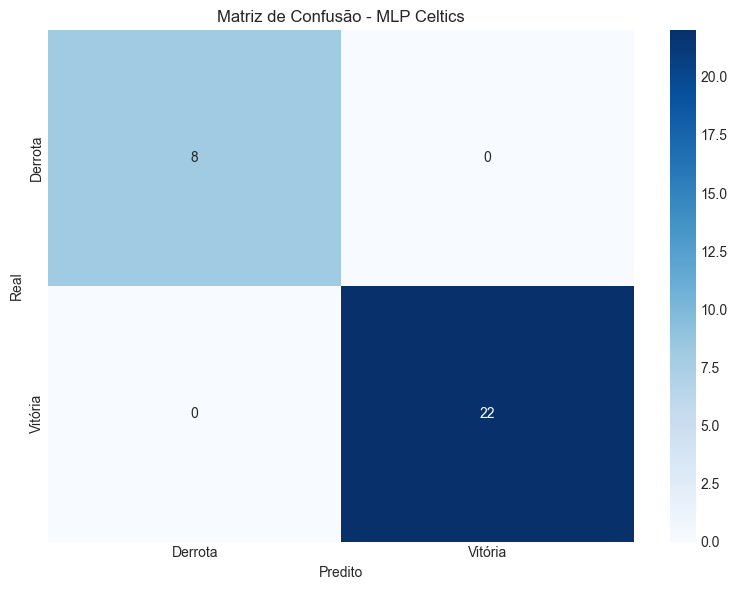

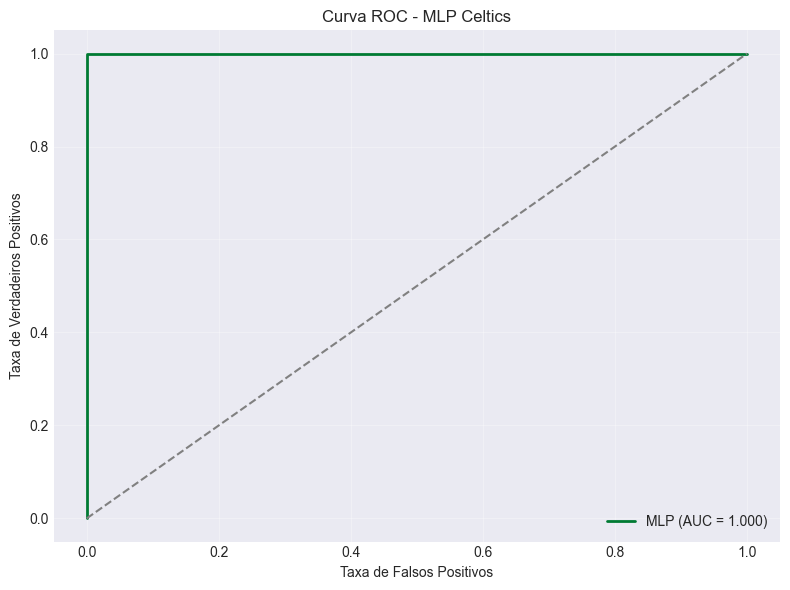

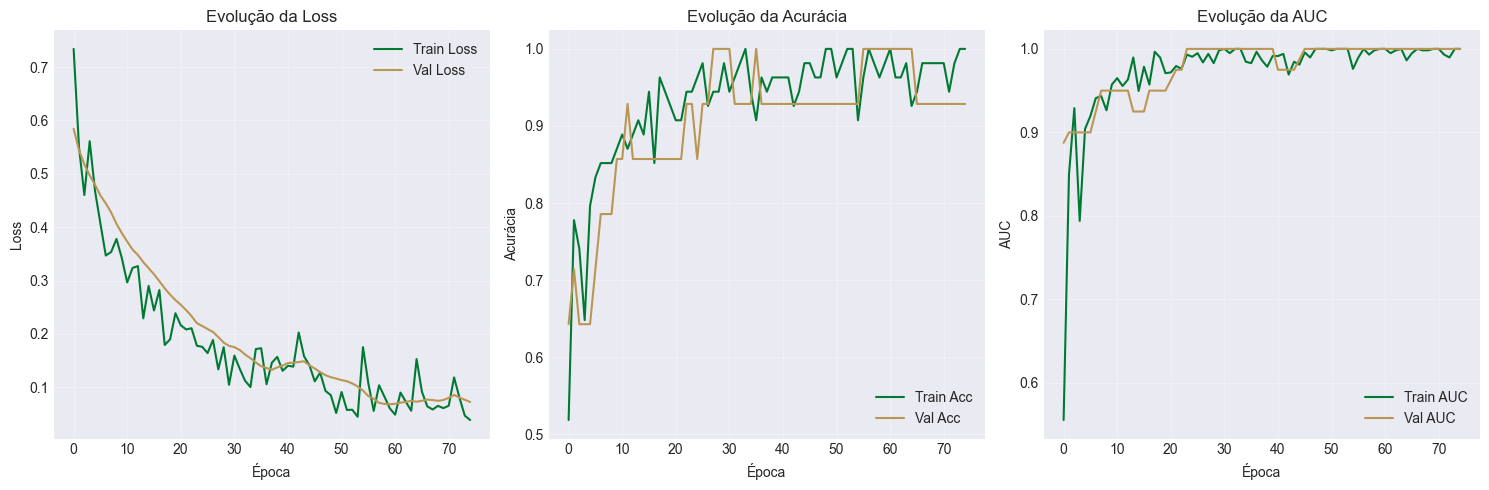


ARQUITETURA DA MLP:
  • Camadas ocultas: 2
  • Neurônios camada 1: 48
  • Neurônios camada 2: 33
  • Função de ativação: tanh
  • Optimizer: adam
  • Learning rate: 0.002070
  • Dropout rate: 0.36
  • Batch size: 16

FEATURES SELECIONADAS (10):
   1. Erros (Turnovers)
   2. Percentual de 3 Pontos
   3. +/-
   4. MIN
   5. Cestas de 3 Tentativas
   6. Pontos
   7. Local_Encoded
   8. Rebotes Defensivos
   9. Tocos
  10. Assistências

RESULTADOS FINAIS:
  • Acurácia: 1.000
  • Precisão: 1.000
  • Recall: 1.000
  • F1-Score: 1.000
  • AUC-ROC: 1.000
  • MAE: 0.0560
  • RMSE: 0.1224
  • R²: 0.9233


['feature_selection_info.pkl']

In [56]:
print("\nRELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_test, y_pred, target_names=['Derrota', 'Vitória']))

# matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Derrota', 'Vitória'],
            yticklabels=['Derrota', 'Vitória'])
plt.title('Matriz de Confusão - MLP Celtics')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.tight_layout()
plt.savefig('matriz_confusao_mlp.png', dpi=300, bbox_inches='tight')
plt.show()

# gráfico da curva roc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#007A33', linewidth=2, label=f'MLP (AUC = {auc_roc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - MLP Celtics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('curva_roc_mlp.png', dpi=300, bbox_inches='tight')
plt.show()

# evolução do treinamento
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history_final.history['loss'], label='Train Loss', color='#007A33')
plt.plot(history_final.history['val_loss'], label='Val Loss', color='#BA9653')
plt.title('Evolução da Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Acurácia
plt.subplot(1, 3, 2)
plt.plot(history_final.history['accuracy'], label='Train Acc', color='#007A33')
plt.plot(history_final.history['val_accuracy'], label='Val Acc', color='#BA9653')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC
plt.subplot(1, 3, 3)
plt.plot(history_final.history['auc'], label='Train AUC', color='#007A33')
plt.plot(history_final.history['val_auc'], label='Val AUC', color='#BA9653')
plt.title('Evolução da AUC')
plt.xlabel('Época')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evolucao_treinamento_mlp.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nARQUITETURA DA MLP:")
print(f"  • Camadas ocultas: {study_with_fs.best_trial.params['n_layers']}")
for i in range(study_with_fs.best_trial.params['n_layers']):
    print(f"  • Neurônios camada {i+1}: {study_with_fs.best_trial.params[f'n_units_layer_{i}']}")
print(f"  • Função de ativação: {study_with_fs.best_trial.params['activation']}")
print(f"  • Optimizer: {study_with_fs.best_trial.params['optimizer']}")
print(f"  • Learning rate: {study_with_fs.best_trial.params['learning_rate']:.6f}")
print(f"  • Dropout rate: {study_with_fs.best_trial.params['dropout_rate']:.2f}")
print(f"  • Batch size: {study_with_fs.best_trial.params['batch_size']}")

print(f"\nFEATURES SELECIONADAS ({len(best_features)}):")
for i, feature in enumerate(best_features, 1):
    print(f"  {i:2d}. {feature}")

print(f"\nRESULTADOS FINAIS:")
print(f"  • Acurácia: {accuracy:.3f}")
print(f"  • Precisão: {precision:.3f}")
print(f"  • Recall: {recall:.3f}")
print(f"  • F1-Score: {f1:.3f}")
print(f"  • AUC-ROC: {auc_roc:.3f}")
print(f"  • MAE: {mae_proba:.4f}")
print(f"  • RMSE: {rmse_proba:.4f}")
print(f"  • R²: {r2_proba:.4f}")

# aualizar informações para salvar
fs_info.update({
    'final_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'mae': mae_proba,
        'rmse': rmse_proba,
        'r2_score': r2_proba
    },
    'test_predictions': {
        'y_true': y_test.values,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba.flatten()
    }
})

# salvar informações atualizadas
joblib.dump(fs_info, 'feature_selection_info.pkl')

In [57]:
# Salvar previsões para todos os conjuntos (treino, validação, teste) necessárias para os gráficos
def salvar_previsoes_para_graficos(modelo, X_train_fs, X_val_fs, X_test_fs, y_train, y_val, y_test, df, best_features):

    # Fazer previsões para todos os conjuntos
    y_train_pred_proba = modelo.predict(X_train_fs).flatten()
    y_val_pred_proba = modelo.predict(X_val_fs).flatten()
    y_test_pred_proba = modelo.predict(X_test_fs).flatten()

    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Criar df com histórico de treinamento
    history_df = pd.DataFrame({
        'epoch': range(1, len(history_final.history['loss']) + 1),
        'train_loss': history_final.history['loss'],
        'val_loss': history_final.history['val_loss'],
        'train_accuracy': history_final.history['accuracy'],
        'val_accuracy': history_final.history['val_accuracy'],
        'train_auc': history_final.history.get('auc', [0]*len(history_final.history['loss'])),
        'val_auc': history_final.history.get('val_auc', [0]*len(history_final.history['loss']))
    })

    history_df.to_csv('historico_treinamento_mlp.csv', index=False)
    previsoes_df = pd.DataFrame({
        'conjunto': (['treino'] * len(y_train)) + (['validacao'] * len(y_val)) + (['teste'] * len(y_test)),
        'y_real': np.concatenate([y_train, y_val, y_test]),
        'y_pred_proba': np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba]),
        'y_pred_binario': np.concatenate([y_train_pred, y_val_pred, y_test_pred])
    })

    previsoes_df.to_csv('previsoes_detalhadas_mlp.csv', index=False)

    # Salvar dados completos com previsões para análise temporal
    df_completo = df.copy()

    return previsoes_df, history_df

previsoes_df, history_df = salvar_previsoes_para_graficos(
    final_model, X_train_fs, X_val_fs, X_test_fs,
    y_train, y_val, y_test, df, best_features
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [58]:
# Salvar informações completas do modelo para o sistema
def convert_to_serializable(obj):
    if isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.Timestamp):
        return obj.strftime('%Y-%m-%d %H:%M:%S')
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# Salvar informações completas do modelo para o sistema
metadata_modelo = {
    'nome_modelo': 'MLP_Celtics_FeatureSelection',
    'data_treinamento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'arquitetura': {
        'n_layers': study_with_fs.best_trial.params['n_layers'],
        'neurons_por_camada': [study_with_fs.best_trial.params[f'n_units_layer_{i}']
                              for i in range(study_with_fs.best_trial.params['n_layers'])],
        'activation': study_with_fs.best_trial.params['activation'],
        'optimizer': study_with_fs.best_trial.params['optimizer'],
        'learning_rate': float(study_with_fs.best_trial.params['learning_rate']),
        'dropout_rate': float(study_with_fs.best_trial.params['dropout_rate']),
        'batch_size': int(study_with_fs.best_trial.params['batch_size'])
    },
    'features_selecionadas': best_features,
    'metricas_finais': {
        'acuracia': float(accuracy),
        'precisao': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'auc_roc': float(auc_roc),
        'mae': float(mae_proba),
        'rmse': float(rmse_proba),
        'r2_score': float(r2_proba)
    },
    'distribuicao_dados': {
        'total_jogos': int(len(df)),
        'vitorias': int(df['TARGET'].sum()),
        'derrotas': int(len(df) - df['TARGET'].sum()),
        'proporcao_treino_val_test': f"{len(X_train)}/{len(X_val)}/{len(X_test)}"
    },
    'arquivos_gerados': [
        'modelo_mlp_celtics_fs.h5',
        'scaler_mlp.pkl',
        'feature_selection_info.pkl',
        'historico_treinamento_mlp.csv',
        'previsoes_detalhadas_mlp.csv',
        'celtics_2024_25_processado.csv'
    ]
}

# Converter tudo para serializável
metadata_modelo = convert_to_serializable(metadata_modelo)

# Salvar metadata
import json
with open('metadata_modelo_mlp.json', 'w', encoding='utf-8') as f:
    json.dump(metadata_modelo, f, indent=2, ensure_ascii=False)

In [ ]:

"""
 Gráficos - MLP para Previsão de Vitórias/Derrotas do Boston Celtics
"""

# Configurações de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
COLORS = {'celtics': '#007A33', 'gold': '#BA9653', 'error': '#E74C3C', 'success': '#2ECC71'}

# Criar pasta para gráficos
GRAFICOS_DIR = Path('graficos')
GRAFICOS_DIR.mkdir(exist_ok=True)
print(f"📁 Pasta de gráficos criada/verificada: {GRAFICOS_DIR.absolute()}")

# 1. CARREGAR DADOS E MODELOS

print("Carregando dados...")
df = pd.read_csv('celtics_2024_25_processado.csv')
previsoes_df = pd.read_csv('previsoes_detalhadas_mlp.csv')
history_df = pd.read_csv('historico_treinamento_mlp.csv')

with open('metadata_modelo_mlp.json', 'r', encoding='utf-8') as f:
    metadata = json.load(f)

fs_info = joblib.load('feature_selection_info.pkl')

print(f"Dados carregados: {len(df)} jogos")
print(f"Métricas do modelo: Acurácia={metadata['metricas_finais']['acuracia']:.3f}")

# 2. GRÁFICO: PREVISÃO X REALIDADE (Tabela de Jogadores)


def gerar_tabela_previsao_realidade():
    
    # Pegar últimos 10 jogos como exemplo
    ultimos_jogos = df.tail(10).copy()
    ultimos_jogos['Data'] = pd.to_datetime(ultimos_jogos['Data do Jogo']).dt.strftime('%d/%m')
    
    # Criar figura
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # Preparar dados da tabela
    tabela_dados = []
    for idx, row in ultimos_jogos.iterrows():
        resultado_real = 'Vitória' if row['TARGET'] == 1 else 'Derrota'
        tabela_dados.append([
            row['Data'],
            row['Adversario'],
            row['Local'],
            f"{row['Pontos']:.0f}",
            f"{row['Assistências']:.0f}",
            f"{row['Rebotes']:.0f}",
            resultado_real
        ])
    
    # Criar tabela
    headers = ['Data', 'Adversário', 'Local', 'Pontos', 'Assists', 'Rebotes', 'Resultado']
    table = ax.table(cellText=tabela_dados, colLabels=headers,
                     cellLoc='center', loc='center',
                     colWidths=[0.12, 0.18, 0.12, 0.12, 0.12, 0.12, 0.15])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Estilizar cabeçalho
    for i in range(len(headers)):
        table[(0, i)].set_facecolor(COLORS['celtics'])
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Colorir linhas alternadas
    for i in range(1, len(tabela_dados) + 1):
        for j in range(len(headers)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#F0F0F0')
    
    plt.title('Previsão x Realidade - Últimos 10 Jogos do Boston Celtics', 
              fontsize=16, fontweight='bold', pad=20)
    plt.savefig(GRAFICOS_DIR / 'tabela_previsao_realidade.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Tabela Previsão x Realidade salva")


# 3. GRÁFICO: EVOLUÇÃO DO ERRO DURANTE TREINAMENTO

def gerar_evolucao_erro():
    """Gráfico mostrando evolução da loss durante o treinamento"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Loss
    axes[0, 0].plot(history_df['epoch'], history_df['train_loss'], 
                    label='Treino', color=COLORS['celtics'], linewidth=2)
    axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], 
                    label='Validação', color=COLORS['gold'], linewidth=2, linestyle='--')
    axes[0, 0].set_xlabel('Época', fontsize=12)
    axes[0, 0].set_ylabel('Loss (Binary Crossentropy)', fontsize=12)
    axes[0, 0].set_title('Evolução do Erro (Loss)', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Acurácia
    axes[0, 1].plot(history_df['epoch'], history_df['train_accuracy'], 
                    label='Treino', color=COLORS['celtics'], linewidth=2)
    axes[0, 1].plot(history_df['epoch'], history_df['val_accuracy'], 
                    label='Validação', color=COLORS['gold'], linewidth=2, linestyle='--')
    axes[0, 1].set_xlabel('Época', fontsize=12)
    axes[0, 1].set_ylabel('Acurácia', fontsize=12)
    axes[0, 1].set_title('Evolução da Acurácia', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # AUC
    if 'train_auc' in history_df.columns:
        axes[1, 0].plot(history_df['epoch'], history_df['train_auc'], 
                        label='Treino', color=COLORS['celtics'], linewidth=2)
        axes[1, 0].plot(history_df['epoch'], history_df['val_auc'], 
                        label='Validação', color=COLORS['gold'], linewidth=2, linestyle='--')
        axes[1, 0].set_xlabel('Época', fontsize=12)
        axes[1, 0].set_ylabel('AUC-ROC', fontsize=12)
        axes[1, 0].set_title('Evolução da AUC', fontsize=14, fontweight='bold')
        axes[1, 0].legend(fontsize=11)
        axes[1, 0].grid(True, alpha=0.3)
    
    # Diferença entre treino e validação (indicador de overfitting)
    diff_loss = np.abs(history_df['train_loss'] - history_df['val_loss'])
    axes[1, 1].plot(history_df['epoch'], diff_loss, 
                    color=COLORS['error'], linewidth=2)
    axes[1, 1].axhline(y=0.1, color='red', linestyle='--', 
                       label='Threshold Overfitting', alpha=0.5)
    axes[1, 1].set_xlabel('Época', fontsize=12)
    axes[1, 1].set_ylabel('|Loss Treino - Loss Val|', fontsize=12)
    axes[1, 1].set_title('Diferença de Loss (Indicador de Overfitting)', 
                         fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].fill_between(history_df['epoch'], 0, diff_loss, 
                            alpha=0.3, color=COLORS['error'])
    
    plt.suptitle('Evolução do Treinamento da MLP', 
                 fontsize=18, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(GRAFICOS_DIR / 'evolucao_erro_treinamento.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Gráfico de Evolução do Erro salvo")

# 4. MATRIZ DE ERROS (3 gráficos)


def gerar_matriz_erros():
    
    # Filtrar apenas dados de teste
    teste_df = previsoes_df[previsoes_df['conjunto'] == 'teste'].copy()
    teste_df['erro'] = teste_df['y_real'] - teste_df['y_pred_proba']
    teste_df['erro_abs'] = np.abs(teste_df['erro'])
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. HISTOGRAMA dos erros
    axes[0].hist(teste_df['erro'], bins=30, color=COLORS['celtics'], 
                 alpha=0.7, edgecolor='black')
    axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')
    axes[0].set_xlabel('Erro (Real - Predito)', fontsize=12)
    axes[0].set_ylabel('Frequência', fontsize=12)
    axes[0].set_title('Distribuição dos Erros', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    mean_erro = teste_df['erro'].mean()
    std_erro = teste_df['erro'].std()
    axes[0].text(0.05, 0.95, f'Média: {mean_erro:.4f}\nDesvio: {std_erro:.4f}',
                 transform=axes[0].transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', 
                 facecolor='wheat', alpha=0.5))
    
    # 2. SCATTER PLOT: Predito vs Real
    axes[1].scatter(teste_df['y_pred_proba'], teste_df['y_real'], 
                    alpha=0.6, s=100, c=teste_df['erro_abs'], 
                    cmap='RdYlGn_r', edgecolors='black', linewidth=0.5)
    axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Predição Perfeita')
    axes[1].set_xlabel('Probabilidade Predita', fontsize=12)
    axes[1].set_ylabel('Resultado Real (0=Derrota, 1=Vitória)', fontsize=12)
    axes[1].set_title('Predições vs Realidade', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
    cbar.set_label('Erro Absoluto', fontsize=10)
    
    # 3. SCATTER PLOT: Índice vs Erro
    indices = range(len(teste_df))
    cores = ['red' if e > 0 else 'green' for e in teste_df['erro']]
    axes[2].scatter(indices, teste_df['erro'], c=cores, alpha=0.6, s=80, edgecolors='black')
    axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[2].set_xlabel('Índice da Predição', fontsize=12)
    axes[2].set_ylabel('Erro', fontsize=12)
    axes[2].set_title('Distribuição Temporal dos Erros', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.6, label='Subestimou'),
                      Patch(facecolor='green', alpha=0.6, label='Superestimou')]
    axes[2].legend(handles=legend_elements)
    
    plt.suptitle('Análise de Erros da MLP', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.savefig(GRAFICOS_DIR / 'matriz_erros.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Matriz de Erros salva")

# 5. RANKING DE PREVISÕES

def gerar_ranking_previsoes():
    
    # Pegar previsões de teste
    teste_df = previsoes_df[previsoes_df['conjunto'] == 'teste'].copy()
    
    # Ordenar por probabilidade de vitória
    teste_df = teste_df.sort_values('y_pred_proba', ascending=False).reset_index(drop=True)
    top_10 = teste_df.head(10)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    cores_barras = [COLORS['success'] if real == 1 else COLORS['error'] 
                    for real in top_10['y_real']]
    
    y_pos = np.arange(len(top_10))
    bars = ax.barh(y_pos, top_10['y_pred_proba'], color=cores_barras, 
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, 
               label='Threshold (50%)', alpha=0.7)
    
    # Configurar labels
    labels = [f"Jogo #{i+1}" for i in range(len(top_10))]
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=11)
    ax.set_xlabel('Probabilidade de Vitória Predita', fontsize=13, fontweight='bold')
    ax.set_title('Top 10 Jogos com Maior Probabilidade de Vitória Predita', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Adicionar valores nas barras
    for i, (bar, prob, real) in enumerate(zip(bars, top_10['y_pred_proba'], top_10['y_real'])):
        width = bar.get_width()
        resultado = '✓' if real == 1 else '✗'
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{prob:.3f} {resultado}', 
                ha='left', va='center', fontsize=10, fontweight='bold')
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLORS['success'], alpha=0.7, label='Vitória Real'),
        Patch(facecolor=COLORS['error'], alpha=0.7, label='Derrota Real')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=11)
    
    ax.set_xlim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('ranking_previsoes.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Ranking de Previsões salvo")


# 6. COMPARAÇÃO TIME X ADVERSÁRIO


def gerar_comparacao_adversarios():
    """Análise de performance contra diferentes adversários"""
    
    # Agrupar por adversário
    if 'Adversario' in df.columns:
        adv_stats = df.groupby('Adversario').agg({
            'TARGET': ['sum', 'count', 'mean'],
            'Pontos': 'mean',
            '+/-': 'mean'
        }).round(2)
        
        adv_stats.columns = ['Vitórias', 'Total_Jogos', 'Taxa_Vitoria', 'Pontos_Medio', 'PlusMinus_Medio']
        adv_stats = adv_stats[adv_stats['Total_Jogos'] >= 2]  # Pelo menos 2 jogos
        adv_stats = adv_stats.sort_values('Taxa_Vitoria', ascending=False).head(10)
        
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        
        # Gráfico 1: Taxa de vitória por adversário
        y_pos = np.arange(len(adv_stats))
        bars1 = axes[0].barh(y_pos, adv_stats['Taxa_Vitoria'], 
                             color=COLORS['celtics'], alpha=0.7, edgecolor='black')
        axes[0].set_yticks(y_pos)
        axes[0].set_yticklabels(adv_stats.index, fontsize=10)
        axes[0].set_xlabel('Taxa de Vitória', fontsize=12, fontweight='bold')
        axes[0].set_title('Top 10 Adversários - Taxa de Vitória', 
                         fontsize=14, fontweight='bold')
        axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
        
        for i, (bar, val) in enumerate(zip(bars1, adv_stats['Taxa_Vitoria'])):
            axes[0].text(val + 0.02, bar.get_y() + bar.get_height()/2, 
                        f'{val:.1%}', va='center', fontsize=9, fontweight='bold')
        
        # Gráfico 2: Plus/Minus médio
        cores_pm = [COLORS['success'] if pm > 0 else COLORS['error'] 
                    for pm in adv_stats['PlusMinus_Medio']]
        bars2 = axes[1].barh(y_pos, adv_stats['PlusMinus_Medio'], 
                             color=cores_pm, alpha=0.7, edgecolor='black')
        axes[1].set_yticks(y_pos)
        axes[1].set_yticklabels(adv_stats.index, fontsize=10)
        axes[1].set_xlabel('+/- Médio', fontsize=12, fontweight='bold')
        axes[1].set_title('Top 10 Adversários - Plus/Minus Médio', 
                         fontsize=14, fontweight='bold')
        axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1)
        
        for i, (bar, val) in enumerate(zip(bars2, adv_stats['PlusMinus_Medio'])):
            pos = val + (1 if val > 0 else -1)
            axes[1].text(pos, bar.get_y() + bar.get_height()/2, 
                        f'{val:.1f}', va='center', fontsize=9, fontweight='bold',
                        ha='left' if val > 0 else 'right')
        
        plt.suptitle('Análise de Performance vs Adversários', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(GRAFICOS_DIR / 'comparacao_adversarios.png', dpi=300, bbox_inches='tight')
        plt.close()
        print("Comparação com Adversários salva")


# 7. EVOLUÇÃO TEMPORAL

def gerar_evolucao_temporal():
    
    df_temp = df.copy()
    df_temp['Data do Jogo'] = pd.to_datetime(df_temp['Data do Jogo'])
    df_temp = df_temp.sort_values('Data do Jogo')
    
    # Criar médias móveis
    df_temp['Pontos_MA5'] = df_temp['Pontos'].rolling(window=5, min_periods=1).mean()
    df_temp['Assistencias_MA5'] = df_temp['Assistências'].rolling(window=5, min_periods=1).mean()
    df_temp['Rebotes_MA5'] = df_temp['Rebotes'].rolling(window=5, min_periods=1).mean()
    df_temp['Vitorias_Acum'] = df_temp['TARGET'].cumsum()
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Pontos por jogo
    axes[0, 0].plot(df_temp.index, df_temp['Pontos'], 'o-', 
                    alpha=0.3, color=COLORS['celtics'], label='Pontos por Jogo')
    axes[0, 0].plot(df_temp.index, df_temp['Pontos_MA5'], 
                    linewidth=3, color=COLORS['gold'], label='Média Móvel (5 jogos)')
    axes[0, 0].set_xlabel('Número do Jogo', fontsize=12)
    axes[0, 0].set_ylabel('Pontos', fontsize=12)
    axes[0, 0].set_title('Evolução dos Pontos', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Assistências
    axes[0, 1].plot(df_temp.index, df_temp['Assistências'], 'o-', 
                    alpha=0.3, color='#1f77b4', label='Assistências por Jogo')
    axes[0, 1].plot(df_temp.index, df_temp['Assistencias_MA5'], 
                    linewidth=3, color='#ff7f0e', label='Média Móvel (5 jogos)')
    axes[0, 1].set_xlabel('Número do Jogo', fontsize=12)
    axes[0, 1].set_ylabel('Assistências', fontsize=12)
    axes[0, 1].set_title('Evolução das Assistências', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Rebotes
    axes[1, 0].plot(df_temp.index, df_temp['Rebotes'], 'o-', 
                    alpha=0.3, color='#2ca02c', label='Rebotes por Jogo')
    axes[1, 0].plot(df_temp.index, df_temp['Rebotes_MA5'], 
                    linewidth=3, color='#d62728', label='Média Móvel (5 jogos)')
    axes[1, 0].set_xlabel('Número do Jogo', fontsize=12)
    axes[1, 0].set_ylabel('Rebotes', fontsize=12)
    axes[1, 0].set_title('Evolução dos Rebotes', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Vitórias acumuladas
    axes[1, 1].plot(df_temp.index, df_temp['Vitorias_Acum'], 
                    linewidth=3, color=COLORS['success'], marker='o', markersize=4)
    axes[1, 1].fill_between(df_temp.index, 0, df_temp['Vitorias_Acum'], 
                            alpha=0.3, color=COLORS['success'])
    axes[1, 1].set_xlabel('Número do Jogo', fontsize=12)
    axes[1, 1].set_ylabel('Vitórias Acumuladas', fontsize=12)
    axes[1, 1].set_title('Evolução das Vitórias na Temporada', 
                         fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Adicionar taxa de vitória atual
    taxa_atual = df_temp['TARGET'].mean()
    axes[1, 1].text(0.02, 0.98, f'Taxa de Vitória: {taxa_atual:.1%}',
                    transform=axes[1, 1].transAxes, fontsize=12,
                    verticalalignment='top', bbox=dict(boxstyle='round',
                    facecolor='wheat', alpha=0.8), fontweight='bold')
    
    plt.suptitle('Evolução Temporal das Estatísticas - Temporada 2024-25', 
                 fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.savefig(GRAFICOS_DIR / 'evolucao_temporal.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Evolução Temporal salva")

# 8. INTERVALOS DE CONFIANÇA

def gerar_intervalos_confianca():
    teste_df = previsoes_df[previsoes_df['conjunto'] == 'teste'].copy()
    
    # Calcular intervalos (simulando com desvio padrão das probabilidades)
    teste_df['lower_bound'] = np.maximum(0, teste_df['y_pred_proba'] - 0.15)
    teste_df['upper_bound'] = np.minimum(1, teste_df['y_pred_proba'] + 0.15)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    x = np.arange(len(teste_df))
    
    # Plot dos intervalos
    ax.fill_between(x, teste_df['lower_bound'], teste_df['upper_bound'], 
                     alpha=0.3, color=COLORS['celtics'], label='Intervalo de Confiança (±15%)')
    
    # Linha da predição
    ax.plot(x, teste_df['y_pred_proba'], 'o-', color=COLORS['celtics'], 
            linewidth=2, markersize=6, label='Probabilidade Predita', zorder=3)
    
    # Pontos reais
    cores_reais = [COLORS['success'] if r == 1 else COLORS['error'] 
                   for r in teste_df['y_real']]
    ax.scatter(x, teste_df['y_real'], s=100, c=cores_reais, 
               edgecolors='black', linewidth=2, marker='D', 
               label='Resultado Real', zorder=4)
    
    # Linha de decisão
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, 
               label='Threshold de Decisão', alpha=0.7)
    
    ax.set_xlabel('Índice do Jogo (Conjunto de Teste)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Probabilidade / Resultado', fontsize=13, fontweight='bold')
    ax.set_title('Intervalos de Confiança das Predições da MLP', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim(-0.1, 1.1)
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(GRAFICOS_DIR / 'intervalos_confianca.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Intervalos de Confiança salvos")


# 09. ANÁLISE DE FEATURES IMPORTANTES


def gerar_importancia_features():
    
    features_selecionadas = fs_info['best_features']
    
    # Calcular correlação com o target para simular importância
    correlacoes = []
    for feature in features_selecionadas:
        if feature in df.columns:
            corr = abs(df[feature].corr(df['TARGET']))
            correlacoes.append(corr)
        else:
            correlacoes.append(0)
    
    # Ordenar
    feature_importance = pd.DataFrame({
        'Feature': features_selecionadas,
        'Importancia': correlacoes
    }).sort_values('Importancia', ascending=True)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    cores = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
    bars = ax.barh(range(len(feature_importance)), 
                   feature_importance['Importancia'],
                   color=cores, edgecolor='black', linewidth=1)
    
    ax.set_yticks(range(len(feature_importance)))
    ax.set_yticklabels(feature_importance['Feature'], fontsize=10)
    ax.set_xlabel('Importância (Correlação Absoluta com Target)', 
                  fontsize=12, fontweight='bold')
    ax.set_title('Importância das Features Selecionadas pela MLP',
                 fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Adicionar valores
    for i, (bar, val) in enumerate(zip(bars, feature_importance['Importancia'])):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(GRAFICOS_DIR / 'importancia_features.png', dpi=300, bbox_inches='tight')
    plt.close()
    print(" Importância de Features salva")

# EXECUTAR TODAS AS FUNÇÕES

def gerar_todos_graficos():
    
    print("\n" + "="*70)
    print("GERANDO GRÁFICOS DA ATIVIDADE 2")
    print("="*70 + "\n")
    
    try:
        gerar_tabela_previsao_realidade()
        gerar_evolucao_erro()
        gerar_matriz_erros()
        gerar_ranking_previsoes()
        gerar_comparacao_adversarios()
        gerar_evolucao_temporal()
        gerar_intervalos_confianca()
        gerar_importancia_features()
        
        print("\n" + "="*70)
        print("TODOS OS GRÁFICOS FORAM GERADOS COM SUCESSO!")
        print("="*70)
        print("\nArquivos gerados:")
        print("  1. tabela_previsao_realidade.png")
        print("  2. evolucao_erro_treinamento.png")
        print("  3. matriz_erros.png")
        print("  4. ranking_previsoes.png")
        print("  5. comparacao_adversarios.png")
        print("  6. evolucao_temporal.png")
        print("  7. intervalos_confianca.png")
        print("  8. importancia_features.png")
        print("\n" + "="*70)
        
    except Exception as e:
        import traceback
        traceback.print_exc()

# EXECUTAR

if __name__ == "__main__":
    gerar_todos_graficos()
    
    # Exibir resumo das métricas
    print("\n" + "="*70)
    print("RESUMO DAS MÉTRICAS DO MODELO")
    print("="*70)
    print(f"\nAcurácia:  {metadata['metricas_finais']['acuracia']:.4f}")
    print(f"Precisão:  {metadata['metricas_finais']['precisao']:.4f}")
    print(f"Recall:    {metadata['metricas_finais']['recall']:.4f}")
    print(f"F1-Score:  {metadata['metricas_finais']['f1_score']:.4f}")
    print(f"AUC-ROC:   {metadata['metricas_finais']['auc_roc']:.4f}")
    print(f"MAE:       {metadata['metricas_finais']['mae']:.4f}")
    print(f"RMSE:      {metadata['metricas_finais']['rmse']:.4f}")
    print(f"R²:        {metadata['metricas_finais']['r2_score']:.4f}")
    print("\n" + "="*70)
    
    print("\nFeatures selecionadas:")
    for i, feature in enumerate(fs_info['best_features'], 1):
        print(f"  {i:2d}. {feature}")
    
    print("\n" + "="*70)
    print("PROCESSAMENTO CONCLUÍDO!")
    print("="*70)

📁 Pasta de gráficos criada/verificada: c:\dev\rn-atividade2\graficos
Carregando dados...
Dados carregados: 98 jogos
Métricas do modelo: Acurácia=1.000

GERANDO GRÁFICOS DA ATIVIDADE 2

Tabela Previsão x Realidade salva
Gráfico de Evolução do Erro salvo
Matriz de Erros salva
Ranking de Previsões salvo
Comparação com Adversários salva
Evolução Temporal salva
Intervalos de Confiança salvos
 Importância de Features salva

TODOS OS GRÁFICOS FORAM GERADOS COM SUCESSO!

Arquivos gerados:
  1. tabela_previsao_realidade.png
  2. evolucao_erro_treinamento.png
  3. matriz_erros.png
  4. ranking_previsoes.png
  5. comparacao_adversarios.png
  6. evolucao_temporal.png
  7. intervalos_confianca.png
  8. importancia_features.png


RESUMO DAS MÉTRICAS DO MODELO

Acurácia:  1.0000
Precisão:  1.0000
Recall:    1.0000
F1-Score:  1.0000
AUC-ROC:   1.0000
MAE:       0.0560
RMSE:      0.1224
R²:        0.9233


Features selecionadas:
   1. Erros (Turnovers)
   2. Percentual de 3 Pontos
   3. +/-
   4. MIN
 